In [2]:
from sklearn.metrics import rand_score, silhouette_score, confusion_matrix, davies_bouldin_score, calinski_harabasz_score
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import gower
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from scipy.spatial.distance import squareform
from scipy.optimize import linear_sum_assignment
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import pairwise_distances

In [3]:
file_path = 'data_preprocessed.csv'
data = pd.read_csv(file_path)
data = data.dropna()


# Identify numerical and categorical columns
numerical_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss']  # Replace with your actual numerical columns
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']  # Replace with your actual categorical columns
sorted_columns = ['age','fnlwgt', 'hours-per-week', 'capital-gain', 'capital-loss', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# scaler = StandardScaler()
# data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

y = pd.get_dummies(data['income'], drop_first=True)
y = y.values.reshape(-1)
X = data.drop('income', axis=1)

for col in categorical_columns:
    X[col] = X[col].astype('category')

X = X[sorted_columns]

X, _, y, _ = train_test_split(X, y, train_size=500, stratify=y, random_state=42)

In [4]:
gower_dist = gower.gower_matrix(X, cat_features = [False]*len(numerical_columns)+[True]*len(categorical_columns))

In [5]:
# range for the number of clusters
range_n_clusters = list(range(2, 11))

In [6]:
# dictionary to store results
results = {
    'PAM': [],
    'AGNES_single': [],
    'AGNES_complete': [],
    'AGNES_average': [],
    'AGNES_ward': [],
    'KPrototypes': []
}

In [6]:
# PAM (KMedoids)
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='random')
    cluster_labels = kmedoids.fit_predict(gower_dist)
    
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
    db_score = davies_bouldin_score(gower_dist, cluster_labels)
    ch_score = calinski_harabasz_score(gower_dist, cluster_labels)
    inertia = kmedoids.inertia_
    
    results['PAM'].append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_score': db_score,
        'calinski_harabasz_score': ch_score,
        'inertia': inertia
    })

In [8]:
# AGNES (All Linkage Methods)
gower_condensed = squareform(gower_dist, checks=False)

linkage_methods = ['single', 'complete', 'average', 'ward']
for method in linkage_methods:
    agnes = linkage(gower_condensed, method=method)
    for n_clusters in range_n_clusters:
        cluster_labels = fcluster(agnes, n_clusters, criterion='maxclust')
        
        silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
        db_score = davies_bouldin_score(gower_dist, cluster_labels)
        ch_score = calinski_harabasz_score(gower_dist, cluster_labels)
        
        results[f'AGNES_{method}'].append({
            'n_clusters': n_clusters,
            'silhouette_score': silhouette_avg,
            'davies_bouldin_score': db_score,
            'calinski_harabasz_score': ch_score
        })

In [10]:
[X.columns.get_loc(col) for col in categorical_columns]

[5, 6, 7, 8, 9, 10, 11, 12]

In [11]:
# KPrototypes
categorical_indices = [X.columns.get_loc(col) for col in categorical_columns]
for n_clusters in range_n_clusters:
    kprototypes = KPrototypes(n_clusters=n_clusters)
    cluster_labels = kprototypes.fit_predict(X, categorical=categorical_indices)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    db_score = davies_bouldin_score(X, cluster_labels)
    ch_score = calinski_harasz_score(X, cluster_labels)
    inertia = kprototypes.cost_
    
    results['KPrototypes'].append({
        'n_clusters': n_clusters,
        'silhouette_score': silhouette_avg,
        'davies_bouldin_score': db_score,
        'calinski_harabasz_score': ch_score,
        'inertia': inertia
    })

ValueError: could not convert string to float: 'Self-emp-not-inc'

# PAM  (KMEDIOIDS)

https://scikit-learn-extra.readthedocs.io/en/stable/generated/sklearn_extra.cluster.KMedoids.html

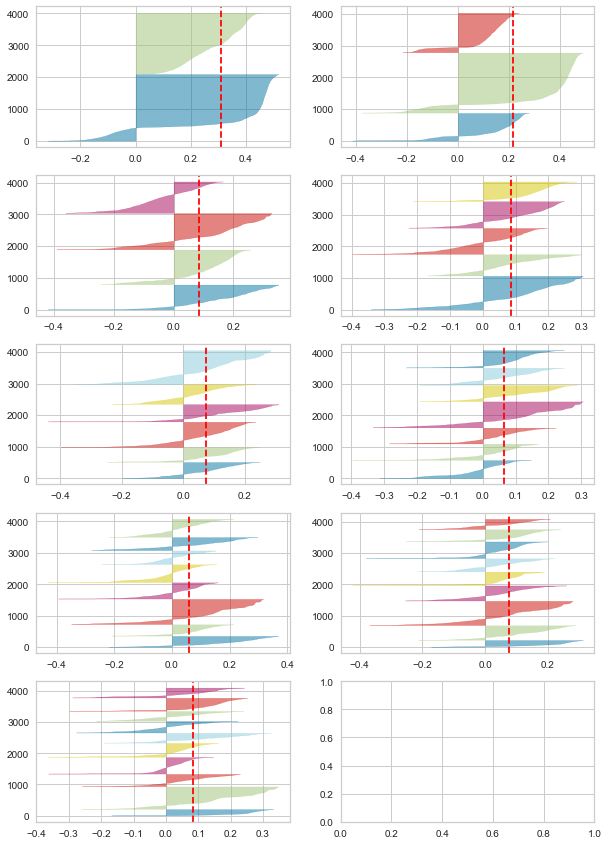

In [9]:
# Define a range for the number of clusters
range_n_clusters = list(range(2, 11))

# Initialize variables to store results
kmedoids_silhouette_scores = []
kmedoids_rand_scores = []
kmedoids_agreement_scores = []
kmedoids_cluster_counts = []
wcss = []

fig, ax = plt.subplots(3, 3, figsize=(10,15))
# Perform KMedoids clustering and calculate silhouette scores for each number of clusters
for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed', method='pam', init='random')
    # cluster_labels = kmedoids.fit_predict(gower_dist)
    
    # silhouette_avg = silhouette_score(gower_dist, cluster_labels)
    # rand_index = rand_score(y, cluster_labels)
    # agreement_score = agreement(y, cluster_labels)
    # cluster_counts = np.bincount(cluster_labels)
    
    # wcss.append(kmedoids.inertia_)
    # kmedoids_silhouette_scores.append(silhouette_avg)
    # kmedoids_rand_scores.append(rand_index)
    # kmedoids_agreement_scores.append(agreement_score)
    # kmedoids_cluster_counts.append(cluster_counts)
    # print(f"For n_clusters = {n_clusters}, the average silhouette_score is {silhouette_avg}")
    q, mod = divmod(n_clusters, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer_sil = SilhouetteVisualizer(kmedoids, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer_sil.fit(gower_dist)



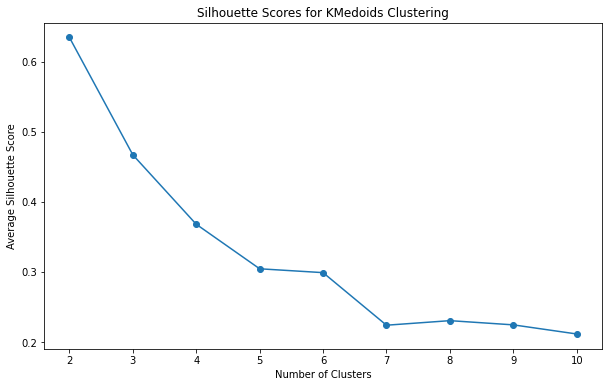

In [38]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
# plt.plot(range_n_clusters, kmedoids_silhouette_scores, marker='o')
# plt.plot(range_n_clusters, kmedoids_rand_scores, marker='o')
plt.plot(range_n_clusters, kmedoids_agreement_scores, marker='o')
plt.title('Silhouette Scores for KMedoids Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

# AGNES (AgglomerativeClustering)

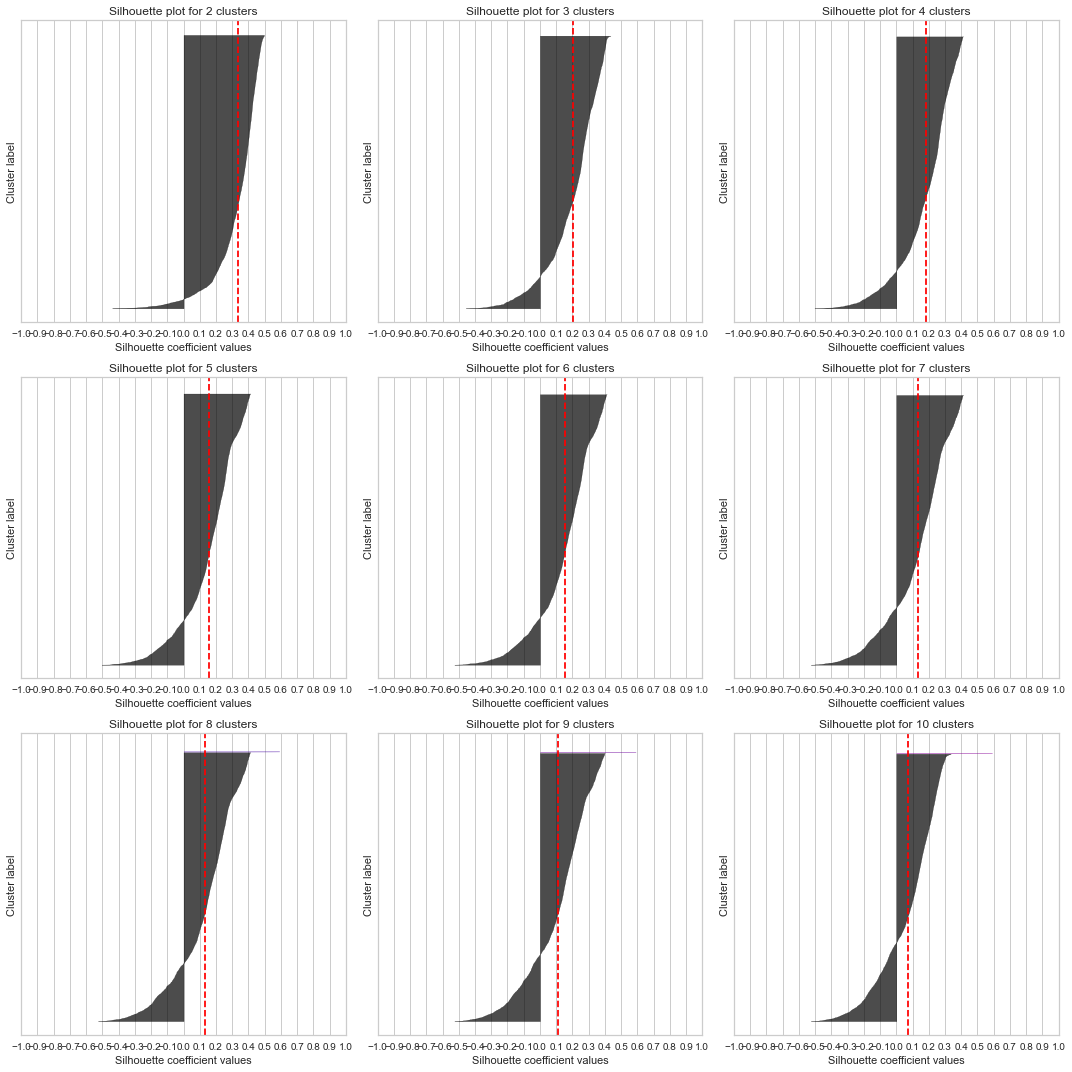

In [6]:
from sklearn.metrics import silhouette_samples
range_n_clusters = list(range(2, 11))

# Create subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
ax = ax.flatten()

# Perform AGNES clustering and calculate silhouette scores for each number of clusters
for idx, n_clusters in enumerate(range_n_clusters):
    agnes = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='single')
    cluster_labels = agnes.fit_predict(gower_dist)
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
    sample_silhouette_values = silhouette_samples(gower_dist, cluster_labels, metric="precomputed")
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax[idx].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        
        y_lower = y_upper + 10
        
    ax[idx].set_title(f"Silhouette plot for {n_clusters} clusters")
    ax[idx].set_xlabel("Silhouette coefficient values")
    ax[idx].set_ylabel("Cluster label")
    
    ax[idx].axvline(x=silhouette_avg, color="red", linestyle="--")
    ax[idx].set_yticks([])  # Clear the y-axis labels / ticks
    ax[idx].set_xticks([i/10.0 for i in range(-10, 11)])

plt.tight_layout()
plt.show()

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

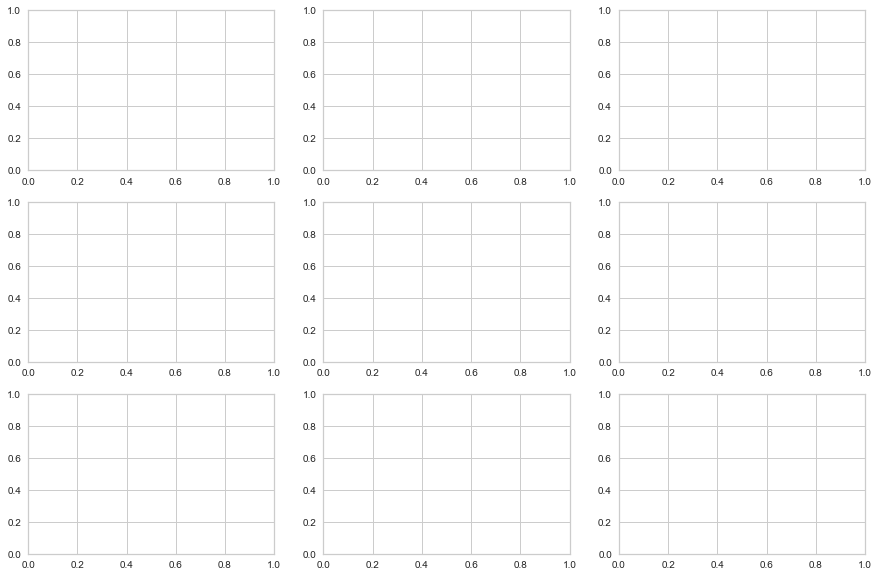

In [13]:
# Define a range for the number of clusters
range_n_clusters = list(range(2, 11))
# gower_condensed = squareform(gower_dist, checks=False)


fig, ax = plt.subplots(3, 3, figsize=(15,10))
# Perform KMedoids clustering and calculate silhouette scores for each number of clusters
for n_clusters in range_n_clusters:
    agnes = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
    q, mod = divmod(n_clusters, 3)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer_sil = SilhouetteVisualizer(agnes, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer_sil.fit(gower_dist)

In [8]:
def calculate_wcss_agnes(data, gower_condensed, range_n_clusters):
    wcss = []
    for n_clusters in range_n_clusters:
        agnes = linkage(gower_condensed, method='average')
        cluster_labels = fcluster(agnes, n_clusters, criterion='maxclust')
        # Calculate the sum of squared distances to the closest cluster center
        cluster_centers = np.array([data[cluster_labels == i].mean(axis=0) for i in np.unique(cluster_labels)])
        dists = np.min(pairwise_distances(data, cluster_centers, metric='euclidean')**2, axis=1)
        wcss.append(dists.sum())
    return wcss

# Calculate WCSS for AGNES
gower_condensed = squareform(gower_dist, checks=False)
wcss_agnes = calculate_wcss_agnes(gower_condensed, gower_dist, range_n_clusters)

# Plot the elbow method for AGNES
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss_agnes, marker='o')
plt.title('Elbow Method for AGNES')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

<ipython-input-8-da04aa02a640>:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  agnes = linkage(gower_condensed, method='average')


IndexError: boolean index did not match indexed array along dimension 0; dimension is 7998000 but corresponding boolean dimension is 4000

In [47]:
gower_condensed = squareform(gower_dist, checks=False)

# Perform hierarchical clustering using linkage
Z = linkage(gower_condensed, method='single')

# Define a range for the number of clusters
range_n_clusters = list(range(2, 11))

# Initialize variables to store results
agnes_silhouette_scores = []
agnes_rand_scores = []
agnes_agreement_scores = []
agnes_cluster_counts = []

# Cut the dendrogram at different levels to form clusters
for n_clusters in range_n_clusters:
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(gower_dist, cluster_labels, metric="precomputed")
    rand_index = rand_score(y, cluster_labels)
    agreement_score = agreement(y, cluster_labels)
    cluster_counts = np.bincount(cluster_labels)
    
    agnes_silhouette_scores.append(silhouette_avg)
    agnes_rand_scores.append(rand_index)
    agnes_agreement_scores.append(agreement_score)
    agnes_cluster_counts.append(cluster_counts)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is {silhouette_avg}")


For n_clusters = 2, the average silhouette_score is 0.3398200571537018
For n_clusters = 3, the average silhouette_score is 0.2663443088531494
For n_clusters = 4, the average silhouette_score is 0.22144900262355804
For n_clusters = 5, the average silhouette_score is 0.16522808372974396
For n_clusters = 6, the average silhouette_score is 0.13956505060195923
For n_clusters = 7, the average silhouette_score is 0.11656785011291504
For n_clusters = 8, the average silhouette_score is 0.11369190365076065
For n_clusters = 9, the average silhouette_score is 0.09503226727247238
For n_clusters = 10, the average silhouette_score is 0.08647327870130539


In [1]:
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, agnes_silhouette_scores, marker='o')
# plt.plot(range_n_clusters, agnes_rand_scores, marker='o')
# plt.plot(range_n_clusters, agnes_agreement_scores, marker='o')
plt.title('Silhouette Scores for AGNES Clustering with Gower Distance')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define a function to plot metrics in one figure
def plot_clustering_metrics(range_n_clusters, agnes_metrics, kmedoids_metrics, metric_names, title):
    fig, axes = plt.subplots(nrows=len(metric_names), ncols=1, figsize=(10, 6 * len(metric_names)))
    
    for i, metric_name in enumerate(metric_names):
        axes[i].plot(range_n_clusters, agnes_metrics[i], marker='o', label='AGNES', color='salmon')
        axes[i].plot(range_n_clusters, kmedoids_metrics[i], marker='o', label='KMedoids', color='cornflowerblue')
        axes[i].set_title(metric_name)
        axes[i].set_xlabel('Number of Clusters')
        axes[i].set_ylabel('Value')
        axes[i].grid(True)
        axes[i].legend()
    
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Define metrics and their names
metric_names = ['Silhouette', 'Dunn', 'Connectivity', 'ARI']
agnes_metrics = [agnes_silhouette_scores, agnes_dunn_scores, agnes_connectivity_scores, agnes_ari_scores]
kmedoids_metrics = [kmedoids_silhouette_scores, kmedoids_dunn_scores, kmedoids_connectivity_scores, kmedoids_ari_scores]

# Plot the metrics
plot_clustering_metrics(range_n_clusters, agnes_metrics, kmedoids_metrics, metric_names, 'Comparison of Clustering Metrics for AGNES and KMedoids')


# EnsembleSpectralClustering? based on PAM

Zapisywać każdy model
wszystkie wyniki zapisuj do plików

Metryki:
silhouette index
Dunn
connectivity
Rand index
liczba obiektów 

Dla agnes dendongram 